### Classification models
##### Without Departure Delay Column

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression, LinearRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report

import xgboost as xgb

##### Load the SQL db for later comparison

In [2]:
import sqlite3
conn=sqlite3.connect("models.db")
cur=conn.cursor()

In [3]:
#Loading the dataset
df=pd.read_csv('depdelay20enc.csv', index_col=False, warn_bad_lines=True, error_bad_lines=False)
df=df.drop(['Unnamed: 0','DepDelay'],axis=1)
df = df.sample(frac =.01).reset_index().drop(['index'], axis=1)
df.head()

,CRSElapsedTime,Distance,ArrDelay,DepTime_sin,DepTime_cos,ArrTime_sin,ArrTime_cos,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos,origin_freq,dest_freq,carrier
0,0.809309,0.701835,1,-0.570714,-0.821149,-0.984196,-0.177085,0.500000,8.660254e-01,0.433884,-0.900969,0.027331,0.010636,0.051448
1,0.320821,-0.577982,1,-0.918791,0.394744,-0.610836,0.791757,0.866025,5.000000e-01,-0.781831,0.623490,0.011053,0.018202,0.028130
2,0.910410,1.240061,1,-0.893371,-0.449319,-0.933580,0.358368,0.866025,-5.000000e-01,0.000000,1.000000,0.017769,0.022350,0.051448
3,0.770771,0.237003,1,-0.946930,0.321439,-0.423409,0.905939,1.000000,6.123234e-17,0.433884,-0.900969,0.016379,0.055796,0.059441
4,0.123123,-0.600917,1,-0.918791,-0.394744,-0.989651,-0.143493,1.000000,6.123234e-17,0.000000,1.000000,0.001825,0.014071,0.034908


##### Split Train and Test  and set ArrDelay as target column

In [4]:
X,y = df.loc[:, df.columns != 'ArrDelay'],df.loc[:, df.columns == 'ArrDelay']

X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42, stratify=y)

##### Support Vector Classification

In [40]:
clf = svm.SVC(kernel='linear', random_state=42, gamma='auto')
scores = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean()
print('Accuracy Score: %.4f' % scores)

Accuracy Score: 0.6606


In [41]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
#y_pred = (clf.predict_proba(X_test)[:,1] = 0.1).astype(bool) # set threshold as 0.3

In [42]:
cm=confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

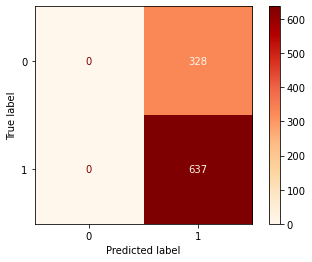

In [43]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot(cmap='OrRd') 

In [44]:
#Specificity = TN / (TN + FP)
spec= round(tn/(tn+fp), 4)
acc= round(metrics.accuracy_score(y_test, y_pred), 4)
prec= round(metrics.precision_score(y_test, y_pred), 4)
rec= round(metrics.recall_score(y_test, y_pred), 4)
f1= round(metrics.f1_score(y_test, y_pred), 4)
print ('Specificity:',spec)
print ('Accuracy:',acc)
print ('Precision:',prec)
print ('Recall or Sensitivity:',rec)
print ('F1 Score:',f1)

Specificity: 0.0
Accuracy: 0.6601
Precision: 0.6601
Recall or Sensitivity: 1.0
F1 Score: 0.7953


In [45]:
model='sv2'
depdelay='no'

cur.execute("INSERT OR REPLACE INTO s13_models(model,dep_delay,Specificity, Accuracy, Precision, Recall, f1_score) VALUES(?,?,?,?,?,?,?)",(model,depdelay,spec,acc,prec,rec,f1))
conn.commit()

##### KNN K-Nearest Neighbors

In [46]:
knn = KNeighborsClassifier(n_neighbors=32)
score=cross_val_score(knn, X, y, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean()
print('Accuracy Score: %.4f' % score)

Accuracy Score: 0.6534


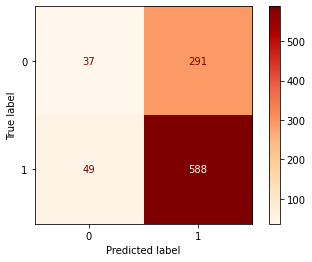

In [47]:
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

cm=confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot(cmap='OrRd') 


In [48]:
spec= round(tn/(tn+fp), 4)
acc= round(metrics.accuracy_score(y_test, y_pred), 4)
prec= round(metrics.precision_score(y_test, y_pred), 4)
rec= round(metrics.recall_score(y_test, y_pred), 4)
f1= round(metrics.f1_score(y_test, y_pred), 4)
print ('Specificity:',spec)
print ('Accuracy:',acc)
print ('Precision:',prec)
print ('Recall or Sensitivity:',rec)
print ('F1 Score:',f1)

Specificity: 0.1128
Accuracy: 0.6477
Precision: 0.6689
Recall or Sensitivity: 0.9231
F1 Score: 0.7757


In [49]:
model='knn2'
depdelay='no'

cur.execute("INSERT OR REPLACE INTO s13_models(model,dep_delay,Specificity, Accuracy, Precision, Recall, f1_score) VALUES(?,?,?,?,?,?,?)",(model,depdelay,spec,acc,prec,rec,f1))
conn.commit()




##### logistic regression

In [50]:
logreg = LogisticRegression(solver='liblinear')
score=cross_val_score(logreg, X, y, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean()
print('Accuracy Score: %.4f' % score)

Accuracy Score: 0.6596


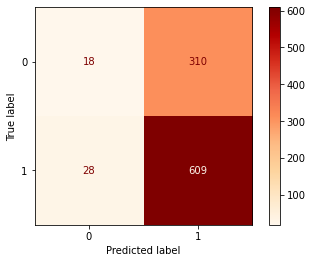

In [51]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

cm=confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot(cmap='OrRd') 

In [52]:
spec= round(tn/(tn+fp), 4)
acc= round(metrics.accuracy_score(y_test, y_pred), 4)
prec= round(metrics.precision_score(y_test, y_pred), 4)
rec= round(metrics.recall_score(y_test, y_pred), 4)
f1= round(metrics.f1_score(y_test, y_pred), 4)
print ('Specificity:',spec)
print ('Accuracy:',acc)
print ('Precision:',prec)
print ('Recall or Sensitivity:',rec)
print ('F1 Score:',f1)

Specificity: 0.0549
Accuracy: 0.6497
Precision: 0.6627
Recall or Sensitivity: 0.956
F1 Score: 0.7828


In [53]:
model='lg2'
depdelay='no'

cur.execute("INSERT OR REPLACE INTO s13_models(model,dep_delay,Specificity, Accuracy, Precision, Recall, f1_score) VALUES(?,?,?,?,?,?,?)",(model,depdelay,spec,acc,prec,rec,f1))
conn.commit()




##### Decision Tree

In [54]:
clf = DecisionTreeClassifier(criterion="gini", max_depth=4, random_state=42)
scores=cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean()
print('Accuracy Score: %.4f' % scores)

Accuracy Score: 0.6606


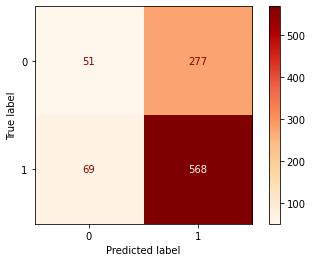

In [55]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cm=confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot(cmap='OrRd') 

In [56]:
spec= round(tn/(tn+fp), 4)
acc= round(metrics.accuracy_score(y_test, y_pred), 4)
prec= round(metrics.precision_score(y_test, y_pred), 4)
rec= round(metrics.recall_score(y_test, y_pred), 4)
f1= round(metrics.f1_score(y_test, y_pred), 4)
print ('Specificity:',spec)
print ('Accuracy:',acc)
print ('Precision:',prec)
print ('Recall or Sensitivity:',rec)
print ('F1 Score:',f1)

Specificity: 0.1555
Accuracy: 0.6415
Precision: 0.6722
Recall or Sensitivity: 0.8917
F1 Score: 0.7665


In [57]:
model='dt2'
depdelay='no'

cur.execute("INSERT OR REPLACE INTO s13_models(model,dep_delay,Specificity, Accuracy, Precision, Recall, f1_score) VALUES(?,?,?,?,?,?,?)",(model,depdelay,spec,acc,prec,rec,f1))
conn.commit()




##### neural network MLPClassifier

In [58]:
mlp = MLPClassifier(hidden_layer_sizes=(20, 10, 5), max_iter=50, activation = 'relu',solver='adam',random_state=42)
score=cross_val_score(mlp, X, y, cv=StratifiedKFold(n_splits=10), scoring='accuracy').mean()
print('Accuracy Score: %.4f' % score)

Accuracy Score: 0.6606


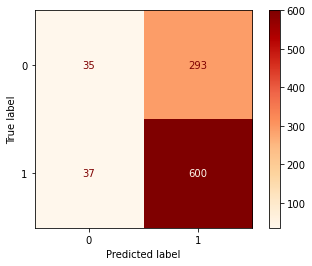

In [59]:
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

cm=confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot(cmap='OrRd') 

In [60]:
spec= round(tn/(tn+fp), 4)
acc= round(metrics.accuracy_score(y_test, y_pred), 4)
prec= round(metrics.precision_score(y_test, y_pred), 4)
rec= round(metrics.recall_score(y_test, y_pred), 4)
f1= round(metrics.f1_score(y_test, y_pred), 4)
print ('Specificity:',spec)
print ('Accuracy:',acc)
print ('Precision:',prec)
print ('Recall or Sensitivity:',rec)
print ('F1 Score:',f1)

Specificity: 0.1067
Accuracy: 0.658
Precision: 0.6719
Recall or Sensitivity: 0.9419
F1 Score: 0.7843


In [61]:
model='nn2'
depdelay='no'

cur.execute("INSERT OR REPLACE INTO s13_models(model,dep_delay,Specificity, Accuracy, Precision, Recall, f1_score) VALUES(?,?,?,?,?,?,?)",(model,depdelay,spec,acc,prec,rec,f1))
conn.commit()

##### Gaussian Naive Bayes

In [62]:
clf = GaussianNB()
score=cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean()
print('Accuracy Score: %.4f' % score)

Accuracy Score: 0.6259


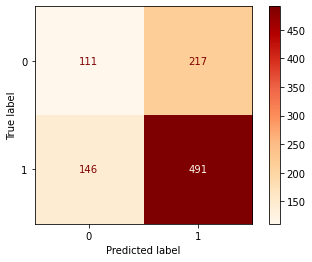

In [63]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cm=confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot(cmap='OrRd') 

In [64]:
spec= round(tn/(tn+fp), 4)
acc= round(metrics.accuracy_score(y_test, y_pred), 4)
prec= round(metrics.precision_score(y_test, y_pred), 4)
rec= round(metrics.recall_score(y_test, y_pred), 4)
f1= round(metrics.f1_score(y_test, y_pred), 4)
print ('Specificity:',spec)
print ('Accuracy:',acc)
print ('Precision:',prec)
print ('Recall or Sensitivity:',rec)
print ('F1 Score:',f1)

Specificity: 0.3384
Accuracy: 0.6238
Precision: 0.6935
Recall or Sensitivity: 0.7708
F1 Score: 0.7301


In [65]:
model='nb2'
depdelay='no'

cur.execute("INSERT OR REPLACE INTO s13_models(model,dep_delay,Specificity, Accuracy, Precision, Recall, f1_score) VALUES(?,?,?,?,?,?,?)",(model,depdelay,spec,acc,prec,rec,f1))
conn.commit()



##### Ada Boost Classifier

In [66]:
ada = AdaBoostClassifier(n_estimators=12, random_state=42,algorithm='SAMME')
score=cross_val_score(ada, X, y, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean()
print('Accuracy Score: %.4f' % score)

Accuracy Score: 0.6611


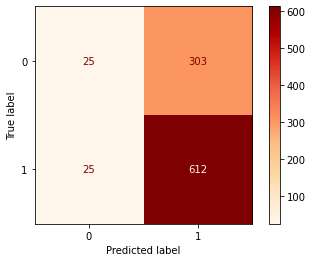

In [67]:
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)

cm=confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='OrRd') 

In [68]:
spec= round(tn/(tn+fp), 4)
acc= round(metrics.accuracy_score(y_test, y_pred), 4)
prec= round(metrics.precision_score(y_test, y_pred), 4)
rec= round(metrics.recall_score(y_test, y_pred), 4)
f1= round(metrics.f1_score(y_test, y_pred), 4)
print ('Specificity:',spec)
print ('Accuracy:',acc)
print ('Precision:',prec)
print ('Recall or Sensitivity:',rec)
print ('F1 Score:',f1)

Specificity: 0.0762
Accuracy: 0.6601
Precision: 0.6689
Recall or Sensitivity: 0.9608
F1 Score: 0.7887


In [69]:
model='ada2'
depdelay='no'

cur.execute("INSERT OR REPLACE INTO s13_models(model,dep_delay,Specificity, Accuracy, Precision, Recall, f1_score) VALUES(?,?,?,?,?,?,?)",(model,depdelay,spec,acc,prec,rec,f1))
conn.commit()

##### Gaussian Process Classifier

In [35]:
gpc = GaussianProcessClassifier(kernel=1*RBF(1.0))
score=cross_val_score(gpc, X, y, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean()
print('Accuracy Score: %.4f' % score)

Accuracy Score: 0.6614


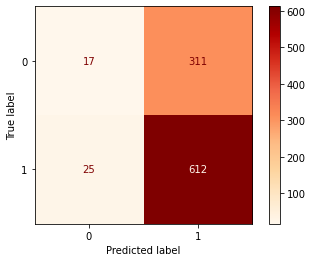

In [36]:
gpc.fit(X_train, y_train)
y_pred = gpc.predict(X_test)

cm=confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='OrRd') 

In [37]:
spec= round(tn/(tn+fp), 4)
acc= round(metrics.accuracy_score(y_test, y_pred), 4)
prec= round(metrics.precision_score(y_test, y_pred), 4)
rec= round(metrics.recall_score(y_test, y_pred), 4)
f1= round(metrics.f1_score(y_test, y_pred), 4)
print ('Specificity:',spec)
print ('Accuracy:',acc)
print ('Precision:',prec)
print ('Recall or Sensitivity:',rec)
print ('F1 Score:',f1)

Specificity: 0.0518
Accuracy: 0.6518
Precision: 0.6631
Recall or Sensitivity: 0.9608
F1 Score: 0.7846


In [38]:
model='gp2'
depdelay='no'

cur.execute("INSERT OR REPLACE INTO s13_models(model,dep_delay,Specificity, Accuracy, Precision, Recall, f1_score) VALUES(?,?,?,?,?,?,?)",(model,depdelay,spec,acc,prec,rec,f1))
conn.commit()

##### xgboost

In [5]:
xg_reg = xgb.XGBClassifier(objective="reg:squarederror", booster="gblinear", colsample_bytree = 0.3, learning_rate = 0.1,
                           max_depth = 5, alpha = 10, n_estimators = 1000, verbosity = 0)
scores = cross_val_score(xg_reg, X, y, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean()
scores

0.6333938159848927

In [6]:
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)

acc = metrics.accuracy_score(y_test, preds)
print("Accuracy: %f" % (acc))

Accuracy: 0.633161


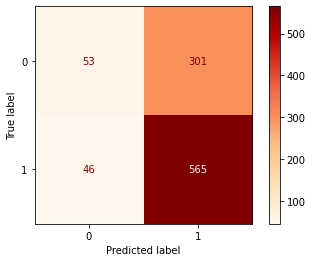

In [7]:
xg_reg.fit(X_train, y_train)
y_pred = xg_reg.predict(X_test)

cm=confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='OrRd') 

In [8]:
spec= round(tn/(tn+fp), 4)
acc= round(metrics.accuracy_score(y_test, y_pred), 4)
prec= round(metrics.precision_score(y_test, y_pred), 4)
rec= round(metrics.recall_score(y_test, y_pred), 4)
f1= round(metrics.f1_score(y_test, y_pred), 4)
print ('Specificity:',spec)
print ('Accuracy:',acc)
print ('Precision:',prec)
print ('Recall or Sensitivity:',rec)
print ('F1 Score:',f1)

Specificity: 0.1497
Accuracy: 0.6404
Precision: 0.6524
Recall or Sensitivity: 0.9247
F1 Score: 0.7651


In [9]:
model='xgb2'
depdelay='no'

cur.execute("INSERT OR REPLACE INTO s13_models(model,dep_delay,Specificity, Accuracy, Precision, Recall, f1_score) VALUES(?,?,?,?,?,?,?)",(model,depdelay,spec,acc,prec,rec,f1))
conn.commit()